#Drive Yükleme Ve Kütüphanelerin İmport Edilmesi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


DATA_DIR = "/content/drive/MyDrive/LLMses/archive (1)"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install librosa scikit-learn numpy soundfile tqdm


#Random Forest İle Sınıflandırma Ve Performans (Ses'den Stress Analizi Kısmı)

In [ ]:
import os
import librosa
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

DATA_DIR = "/content/drive/MyDrive/LLMses/archive (1)"

EMOTION_MAP = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    spec = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    return np.hstack([mfcc, chroma, spec, zcr])

X, y = [], []

for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split("-")
            emotion_id = parts[2]
            label = EMOTION_MAP[emotion_id]
            path = os.path.join(root, file)
            features = extract_features(path)
            X.append(features)
            y.append(label)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

MODEL_PATH = "/content/drive/MyDrive/LLMses/ravdess_emotion_rf.pkl"
joblib.dump(model, MODEL_PATH)

print("Model kaydedildi:", MODEL_PATH)


Test Accuracy: 0.5625
Model kaydedildi: /content/drive/MyDrive/LLMses/ravdess_emotion_rf.pkl


# SGD Sınıflandırma Ve Perfomansı (Ses'den Stress Analizi Kısmı)

In [ ]:
import os
import numpy as np
import librosa
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss

DATA_DIR = "/content/drive/MyDrive/LLMses/archive (1)"
MODEL_PATH = "/content/drive/MyDrive/LLMses/ravdess_emotion_sgd.pkl"

SAMPLE_RATE = 22050
N_MFCC = 40
EPOCHS = 30
EPS = 1e-9

emotion_map = {
    "01": 0,
    "02": 1,
    "03": 2,
    "04": 3,
    "05": 4,
    "06": 5,
    "07": 6,
    "08": 7
}

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    features = np.hstack([
        np.mean(mfcc, axis=1),
        np.mean(chroma, axis=1),
        np.mean(contrast, axis=1),
        np.mean(zcr, axis=1)
    ])
    return features

X = []
y = []

for actor in os.listdir(DATA_DIR):
    actor_path = os.path.join(DATA_DIR, actor)
    if not os.path.isdir(actor_path):
        continue
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            emotion = file.split("-")[2]
            X.append(extract_features(os.path.join(actor_path, file)))
            y.append(emotion_map[emotion])

X = np.array(X)
y = np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

model = SGDClassifier(
    loss="log_loss",
    learning_rate="optimal",
    max_iter=1,
    warm_start=True,
    random_state=42
)

classes = np.unique(y_train)

for epoch in range(EPOCHS):
    model.partial_fit(X_train, y_train, classes=classes)

    train_probs = model.predict_proba(X_train)
    val_probs = model.predict_proba(X_val)

    train_probs = np.clip(train_probs, EPS, 1 - EPS)
    val_probs = np.clip(val_probs, EPS, 1 - EPS)

    train_loss = log_loss(y_train, train_probs)
    val_loss = log_loss(y_val, val_probs)

    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

test_acc = accuracy_score(y_test, model.predict(X_test))
print("Test Accuracy:", test_acc)

joblib.dump(
    {
        "model": model,
        "scaler": scaler
    },
    MODEL_PATH
)

print("Model kaydedildi:", MODEL_PATH)


Epoch 1/30 | Train Loss: 11.1718 | Val Loss: 12.3648 | Train Acc: 0.3601 | Val Acc: 0.3102
Epoch 2/30 | Train Loss: 9.4101 | Val Loss: 10.5229 | Train Acc: 0.4742 | Val Acc: 0.3843
Epoch 3/30 | Train Loss: 9.3885 | Val Loss: 9.7272 | Train Acc: 0.4643 | Val Acc: 0.4676
Epoch 4/30 | Train Loss: 8.8817 | Val Loss: 9.8963 | Train Acc: 0.4752 | Val Acc: 0.4352
Epoch 5/30 | Train Loss: 8.4047 | Val Loss: 9.3858 | Train Acc: 0.4960 | Val Acc: 0.4491
Epoch 6/30 | Train Loss: 8.0110 | Val Loss: 8.4231 | Train Acc: 0.5040 | Val Acc: 0.4722
Epoch 7/30 | Train Loss: 8.4480 | Val Loss: 8.7512 | Train Acc: 0.4782 | Val Acc: 0.4398
Epoch 8/30 | Train Loss: 7.4502 | Val Loss: 7.8669 | Train Acc: 0.5188 | Val Acc: 0.5000
Epoch 9/30 | Train Loss: 7.3398 | Val Loss: 8.2934 | Train Acc: 0.5129 | Val Acc: 0.4306
Epoch 10/30 | Train Loss: 7.1310 | Val Loss: 8.3204 | Train Acc: 0.5218 | Val Acc: 0.4815
Epoch 11/30 | Train Loss: 7.8017 | Val Loss: 8.2200 | Train Acc: 0.4812 | Val Acc: 0.4630
Epoch 12/30 | Tr

#SVM Model Performansı (Ses'den Stress Analizi Kısmı)

In [ ]:
import os
import librosa
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

DATA_DIR = "/content/drive/MyDrive/LLMses/archive (1)"
MODEL_PATH = "/content/drive/MyDrive/LLMses/ravdess_emotion_svm.pkl"

EMOTION_MAP = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    spec = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    return np.hstack([mfcc, chroma, spec, zcr])

X, y = [], []

for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split("-")
            emotion_id = parts[2]
            label = EMOTION_MAP[emotion_id]
            path = os.path.join(root, file)
            try:
                features = extract_features(path)
                X.append(features)
                y.append(label)
            except:
                pass

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        probability=True,
        random_state=42
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print(classification_report(y_test, y_pred))

joblib.dump(model, MODEL_PATH)
print("Model kaydedildi:", MODEL_PATH)


Test Accuracy: 0.7083333333333334
              precision    recall  f1-score   support

       angry       0.72      0.82      0.77        38
        calm       0.76      0.76      0.76        38
     disgust       0.74      0.66      0.69        38
     fearful       0.67      0.74      0.71        39
       happy       0.70      0.59      0.64        39
     neutral       0.54      0.68      0.60        19
         sad       0.72      0.61      0.66        38
   surprised       0.76      0.79      0.78        39

    accuracy                           0.71       288
   macro avg       0.70      0.71      0.70       288
weighted avg       0.71      0.71      0.71       288

Model kaydedildi: /content/drive/MyDrive/LLMses/ravdess_emotion_svm.pkl


#SVM Modeli Performans Sonuçları Grafik Ve Matrisler

<Figure size 800x800 with 0 Axes>

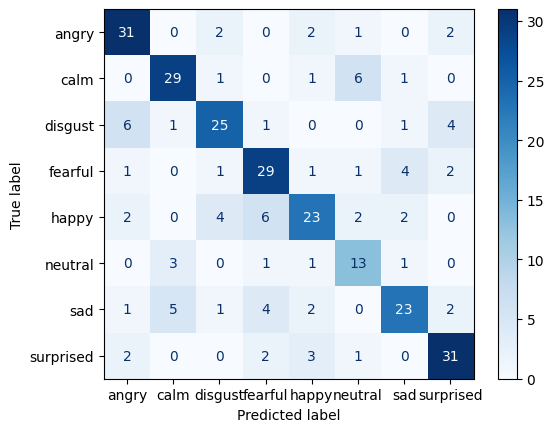

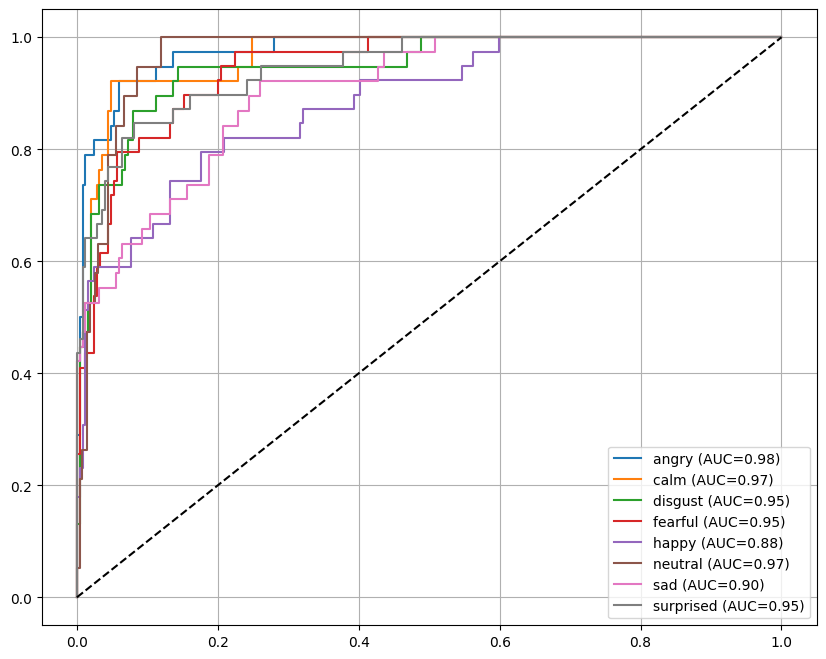

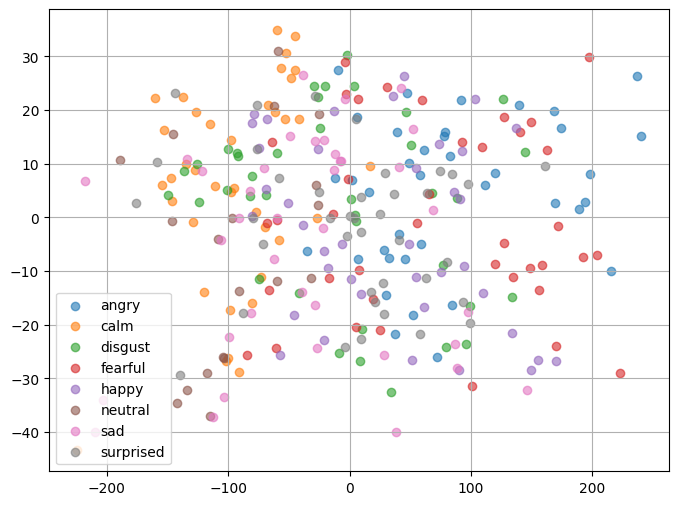

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.show()

y_test_bin = label_binarize(y_test, classes=model.classes_)
y_prob = model.predict_proba(X_test)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.grid()
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8, 6))
for label in np.unique(y_test):
    idx = np.where(y_test == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.6)

plt.legend()
plt.grid()
plt.show()


#Sınıf Tahmini SVM Modeli

In [ ]:
!pip install transformers accelerate -q


In [ ]:
import joblib

svm_model = joblib.load("/content/drive/MyDrive/LLMses/ravdess_emotion_svm.pkl")
print(type(svm_model))


<class 'sklearn.pipeline.Pipeline'>


In [ ]:
def predict_emotion_from_audio(audio_path):
    features = extract_features(audio_path).reshape(1, -1)

    probs = svm_model.predict_proba(features)[0]
    idx = probs.argmax()

    emotion = svm_model.classes_[idx]
    confidence = float(probs[idx])

    return emotion, confidence, probs


In [ ]:
emotion, confidence, probs = predict_emotion_from_audio("/content/drive/MyDrive/LLMses/archive (1)/Actor_02/03-01-01-01-01-01-02.wav")
print(emotion, confidence)
print(probs)


neutral 0.58021973811291
[0.0464032  0.06145455 0.06224055 0.0033029  0.04444606 0.58021974
 0.07110563 0.13082737]


In [ ]:
!pip install -q transformers accelerate bitsandbytes sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 44.3 MB/s eta 0:00:00


In [ ]:
import joblib
import numpy as np
import librosa

svm_model = joblib.load("/content/drive/MyDrive/LLMses/ravdess_emotion_svm.pkl")

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    spec = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    return np.hstack([mfcc, chroma, spec, zcr])

def predict_emotion(audio_path):
    features = extract_features(audio_path)
    return svm_model.predict([features])[0]


#Komut Promptları

In [ ]:

!pip install -q transformers datasets peft accelerate bitsandbytes trl
!pip install -q librosa joblib soundfile


from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 32.0 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/LLMses/turkish_education_dataset.csv')

print("Veri seti boyutu:", df.shape)
print("\nİlk 3 satır:")
print(df.head(3))
print("\nSütun isimleri:")
print(df.columns.tolist())

Veri seti boyutu: (17587, 6)

İlk 3 satır:
                                                soru  \
0  Doğal sistemler birbirleriyle nasıl etkileşim ...   
1  Doğal çevrenin farklı bölgelerinde yaşayan ins...   
2  İnsanlar doğal çevreye nasıl uyum sağlayarak f...   

                                               cevap veri türü  \
0  Doğal sistemler birbirleriyle karmaşık bir şek...    egitim   
1  Doğal çevrenin farklı bölgelerinde yaşayan ins...    egitim   
2  İnsanlar, doğal çevreye uyum sağlayarak farklı...    egitim   

              kaynak                                            context  Score  
0  OGM Konu Ozetleri  DOĞA VE İNSAN ETKİLEŞİMİ\r\nDoğa, başta insan ...      8  
1  OGM Konu Ozetleri  DOĞA VE İNSAN ETKİLEŞİMİ\r\nDoğa, başta insan ...      8  
2  OGM Konu Ozetleri  DOĞA VE İNSAN ETKİLEŞİMİ\r\nDoğa, başta insan ...      8  

Sütun isimleri:
['soru', 'cevap', 'veri türü', 'kaynak', 'context', 'Score']


In [ ]:
train_df = df[df['veri türü'] == 'egitim'].copy()
print(f"\n Eğitim için {len(train_df)} örnek kullanılacak")


EMOTIONS = {
    0: "nötr",
    1: "sakin",
    2: "mutlu",
    3: "üzgün",
    4: "kızgın",
    5: "korkmuş",
    6: "tiksinti",
    7: "şaşkın"
}


EMPATHY_PREFIXES = {
    "nötr": "",
    "sakin": "Anlıyorum, sakin bir şekilde konuşuyorsunuz. ",
    "mutlu": "Harika! Mutlu olmanızdan keyif aldım. ",
    "üzgün": "Üzgün olduğunuzu hissediyorum, sizi anlıyorum. ",
    "kızgın": "Kızgın olduğunuzu anlıyorum, beraber çözüm bulalım. ",
    "korkmuş": "Endişelendiğinizi görüyorum, sizi destekliyorum. ",
    "tiksinti": "Rahatsız olduğunuzu anlıyorum. ",
    "şaşkın": "Bu sizi şaşırtmış görünüyor, açıklayayım. "
}

def create_empathic_prompt(question, answer, emotion):
    """Duygusal farkındalık içeren prompt oluştur"""
    empathy = EMPATHY_PREFIXES.get(emotion, "")

    prompt = f"""### Konuşmacının Duygu Durumu: {emotion.upper()}
### Kullanıcı: {question}
### Asistan: {empathy}{answer}"""

    return prompt


 Eğitim için 12499 örnek kullanılacak


#Veri Dengeleme

In [ ]:

def create_balanced_dataset(df, samples_per_emotion=500):
    """Her duygu için dengeli veri seti oluştur"""
    all_prompts = []


    for emotion_id, emotion_name in EMOTIONS.items():

        sample_size = min(samples_per_emotion, len(df))
        sampled = df.sample(n=sample_size, replace=False)

        for _, row in sampled.iterrows():
            prompt = create_empathic_prompt(
                row['soru'],
                row['cevap'],
                emotion_name
            )
            all_prompts.append({
                'text': prompt,
                'emotion': emotion_name
            })

    return pd.DataFrame(all_prompts)

balanced_df = create_balanced_dataset(train_df, samples_per_emotion=500)

print("\n" + "=" * 60)
print("DENGELI VERİ SETİ OLUŞTURULDU")
print("=" * 60)
print(balanced_df['emotion'].value_counts())
print(f"\nToplam eğitim örneği: {len(balanced_df)}")
print(f"\nÖrnek prompt:\n{balanced_df.iloc[0]['text'][:300]}...")


DENGELI VERİ SETİ OLUŞTURULDU
emotion
nötr        500
sakin       500
mutlu       500
üzgün       500
kızgın      500
korkmuş     500
tiksinti    500
şaşkın      500
Name: count, dtype: int64

Toplam eğitim örneği: 4000

Örnek prompt:
### Konuşmacının Duygu Durumu: NÖTR
### Kullanıcı: Dağınık yerleşmelerin hangi bölgelerde yaygın olmasının nedeni nedir?
### Asistan: Dağınık yerleşmeler daha çok Karadeniz, Akdeniz ve Doğu Anadolu Bölgeleri'nin bazı kesimlerinde görülür. Bu bölgelerin dağlık ve engebeli arazisi, tarım alanlarının k...


#Model Yüklemesi gpt2Large

In [ ]:

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import Dataset
import torch

print("\n" + "=" * 60)
print("MODEL YÜKLEME")
print("=" * 60)


MODEL_NAME = "ytu-ce-cosmos/turkish-gpt2-large"


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"


model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)


lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)


model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

print(" Model başarıyla yüklendi!")


MODEL YÜKLEME


tokenizer_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 8,110,080 || all params: 782,140,160 || trainable%: 1.0369
 Model başarıyla yüklendi!


#Model Tokenizer

In [ ]:
def tokenize_function(examples):
    """Metinleri tokenize et"""
    result = tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )
    result["labels"] = result["input_ids"].copy()
    return result


train_dataset = Dataset.from_pandas(balanced_df[['text']])


print("\n" + "=" * 60)
print("TOKENİZASYON")
print("=" * 60)
tokenized_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

print(f"{len(tokenized_dataset)} örnek tokenize edildi")


TOKENİZASYON


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

4000 örnek tokenize edildi


#LLM Model Eğitimi

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/LLMses/empathic_model_checkpoints",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
    warmup_steps=100,
    report_to="none",
    optim="paged_adamw_8bit"
)


data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator
)

print("\n" + "=" * 60)
print("EĞİTİM BAŞLIYOR")
print("=" * 60)
print(" Bu işlem yaklaşık 1-2 saat sürebilir...")


trainer.train()


final_model_path = "/content/drive/MyDrive/LLMses/empathic_model_final"
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

print("\n EĞİTİM TAMAMLANDI!")
print(f" Model kaydedildi: {final_model_path}")

The model is already on multiple devices. Skipping the move to device specified in `args`.



EĞİTİM BAŞLIYOR
 Bu işlem yaklaşık 1-2 saat sürebilir...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,77.668800
100,19.086000
150,1.888200
200,1.748600
250,1.666300
300,1.684300
350,1.607600
400,1.564200
450,1.615800
500,1.582300



 EĞİTİM TAMAMLANDI!
 Model kaydedildi: /content/drive/MyDrive/LLMses/empathic_model_final


#SVM VE LLM MODELELLERİNİN BİRLEŞMESİ

In [3]:
import librosa
import joblib
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

class EmpatheticAIAssistant:

    def __init__(self, svm_model_path, llm_model_path):
        print("Asistan yükleniyor...")

        print("SVM modeli yükleniyor...")
        self.svm_model = joblib.load(svm_model_path)
        print("SVM yüklendi")

        print("LLM yükleniyor...")
        self.tokenizer = AutoTokenizer.from_pretrained(llm_model_path)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = AutoModelForCausalLM.from_pretrained(
            llm_model_path,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        print("LLM yüklendi")

        self.emotion_map_eng_to_tr = {
            'neutral': 'nötr',
            'calm': 'sakin',
            'happy': 'mutlu',
            'sad': 'üzgün',
            'angry': 'kızgın',
            'fearful': 'korkmuş',
            'disgust': 'tiksinti',
            'surprised': 'şaşkın'
        }

        self.emotions = {
            0: "nötr", 1: "sakin", 2: "mutlu", 3: "üzgün",
            4: "kızgın", 5: "korkmuş", 6: "tiksinti", 7: "şaşkın"
        }

        print("Asistan hazır")

    def extract_audio_features(self, audio_path):
        y, sr = librosa.load(audio_path, sr=22050)

        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        spectral = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))

        return np.hstack([mfcc, chroma, spectral, zcr])

    def detect_emotion(self, audio_path):
        try:
            features = self.extract_audio_features(audio_path)
            prediction = self.svm_model.predict([features])[0]

            if isinstance(prediction, (str, np.str_)):
                emotion_str = str(prediction).lower()
                emotion = self.emotion_map_eng_to_tr.get(emotion_str, "nötr")
            elif isinstance(prediction, (int, np.integer)):
                emotion = self.emotions.get(int(prediction), "nötr")
            else:
                emotion = "nötr"

            return emotion

        except Exception as e:
            print(f"Duygu tespiti hatası: {e}")
            return "nötr"

    def generate_empathic_response(self, user_text, emotion, conversation_context=None, is_first=False):

        if is_first:
            empathy_first = {
                "nötr": "Merhaba, ",
                "sakin": "Sakin görünüyorsunuz, ",
                "mutlu": "Mutlu görünüyorsunuz, ",
                "üzgün": "Üzgün görünüyorsunuz, ",
                "kızgın": "Gergin görünüyorsunuz, ",
                "korkmuş": "Endişeli görünüyorsunuz, ",
                "tiksinti": "Rahatsız görünüyorsunuz, ",
                "şaşkın": "Şaşırmış görünüyorsunuz, "
            }
            empathy = empathy_first.get(emotion, "")
        else:
            empathy = ""

        if conversation_context and len(conversation_context) > 1:
            last_user = ""
            for msg in reversed(conversation_context):
                if msg['role'] == 'user':
                    last_user = msg['message']
                    break

            prompt = f"""Bir yardımcı asistansın. Kısa ve net cevaplar ver.

Önceki: {last_user}
Şimdi: {user_text}

Cevap: {empathy}"""
        else:
            prompt = f"""Bir yardımcı asistansın. Kısa ve net cevaplar ver.

Soru: {user_text}

Cevap: {empathy}"""

        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=300).to(self.model.device)

        outputs = self.model.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.6,
            top_p=0.85,
            do_sample=True,
            repetition_penalty=1.5,
            no_repeat_ngram_size=3,
            pad_token_id=self.tokenizer.eos_token_id,
            eos_token_id=self.tokenizer.eos_token_id
        )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        if "Cevap:" in response:
            response = response.split("Cevap:")[-1].strip()

        lines = response.split('\n')
        response = lines[0].strip()

        sentences = response.split('.')
        if len(sentences) > 2:
            response = '. '.join(sentences[:2]) + '.'

        if not response or len(response) < 10:
            response = "Size nasıl yardımcı olabilirim?"

        return response

    def process_multimodal_input(self, audio_path, user_text):
        print("\n" + "="*60)
        emotion = self.detect_emotion(audio_path)
        print(f"Tespit Edilen Duygu: {emotion.upper()}")
        response = self.generate_empathic_response(user_text, emotion)
        print(f"Asistan Yanıtı:\n{response}")
        print("="*60 + "\n")
        return emotion, response

print("EmpatheticAIAssistant sınıfı tanımlandı")

EmpatheticAIAssistant sınıfı tanımlandı


In [4]:
if 'assistant' in globals():
    del assistant
    import gc
    gc.collect()
    torch.cuda.empty_cache()

assistant = EmpatheticAIAssistant(
    svm_model_path="/content/drive/MyDrive/LLMses/ravdess_emotion_svm.pkl",
    llm_model_path="/content/drive/MyDrive/LLMses/empathic_model_final"
)

print("Asistan yeniden başlatıldı")

Asistan yükleniyor...
SVM modeli yükleniyor...
SVM yüklendi
LLM yükleniyor...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

LLM yüklendi
Asistan hazır
Asistan yeniden başlatıldı


# Manuel Test

In [5]:

def test_without_audio(text, emotion="nötr"):
    """Ses olmadan test için"""
    print(f"\n TEST - Duygu: {emotion}")
    print(f" Kullanıcı: {text}")

    response = assistant.generate_empathic_response(text, emotion)

    print(f"Asistan: {response}")
    print("="*60)
    return response


test_without_audio("Matematik dersinde zorlanıyorum", emotion="üzgün")
test_without_audio("Sınavdan tam puan aldım!", emotion="mutlu")
test_without_audio("Öğretmen haksız davrandı", emotion="kızgın")


 TEST - Duygu: üzgün
 Kullanıcı: Matematik dersinde zorlanıyorum
Asistan: Zorlandığınızı anlıyorum, sizi destekliyorum.  Matematiğin günlük yaşamla ilişkisini anlamak için matematik dersi çalışma programları oluşturmak önemlidir.

 TEST - Duygu: mutlu
 Kullanıcı: Sınavdan tam puan aldım!
Asistan: Evet, sınavınızdan iyi bir not elde ettiniz.  Bu durum sizi daha fazla çalışmaya teşvik eder ve başarıya ulaşmanızı sağlar.

 TEST - Duygu: kızgın
 Kullanıcı: Öğretmen haksız davrandı
Asistan: Haksız davranış, öğretmenden özür dilemesini gerektirir.  Özür dilenmesi ise öğretmenin itibarını zedeler.


'Haksız davranış, öğretmenden özür dilemesini gerektirir.  Özür dilenmesi ise öğretmenin itibarını zedeler.'

#Arayüz


In [1]:
import gradio as gr

if 'demo' in globals():
    try:
        demo.close()
    except:
        pass

conversation_history = []

def process_audio_initial(audio_file):
    if audio_file is None:
        return "Lütfen ses dosyası yükleyin", "", gr.update(visible=False)

    try:
        emotion = assistant.detect_emotion(audio_file)

        opening_messages = {
            "nötr": "Merhaba, size nasıl yardımcı olabilirim?",
            "sakin": "Sakin görünüyorsunuz, size nasıl yardımcı olabilirim?",
            "mutlu": "Mutlu görünüyorsunuz, size nasıl yardımcı olabilirim?",
            "üzgün": "Üzgün görünüyorsunuz, neler oluyor?",
            "kızgın": "Gergin görünüyorsunuz, ne oldu?",
            "korkmuş": "Endişeli görünüyorsunuz, size nasıl yardımcı olabilirim?",
            "tiksinti": "Rahatsız görünüyorsunuz, neler oluyor?",
            "şaşkın": "Şaşırmış görünüyorsunuz, ne oldu?"
        }

        opening = opening_messages.get(emotion, "Merhaba, size nasıl yardımcı olabilirim?")

        conversation_history.clear()
        conversation_history.append({
            "role": "system",
            "emotion": emotion,
            "message": opening
        })

        emotion_text = f"Tespit Edilen Duygu: {emotion.upper()}"
        chat_display = f"Asistan: {opening}"

        return emotion_text, chat_display, gr.update(visible=True)

    except Exception as e:
        return f"Hata: {str(e)}", "", gr.update(visible=False)

def continue_conversation(user_message, current_chat):
    if not user_message.strip():
        return current_chat, ""

    if not conversation_history:
        return current_chat + "\n\nLütfen önce ses yükleyin", ""

    current_emotion = conversation_history[0]["emotion"]

    is_first_user_message = len([m for m in conversation_history if m['role'] == 'user']) == 0

    response = assistant.generate_empathic_response(
        user_message,
        current_emotion,
        conversation_context=conversation_history,
        is_first=is_first_user_message
    )

    conversation_history.append({
        "role": "user",
        "message": user_message
    })
    conversation_history.append({
        "role": "assistant",
        "message": response
    })

    updated_chat = current_chat + f"\n\nKullanıcı: {user_message}\n\nAsistan: {response}"

    return updated_chat, ""

with gr.Blocks(theme="soft") as demo:
    gr.Markdown("# Duygusal AI Asistanı")
    gr.Markdown("Ses kaydınızı yükleyin, sistem duygusal durumunuza göre sohbete başlayacak")

    with gr.Row():
        audio_input = gr.Audio(type="filepath", label="Ses Kaydı Yükle")
        emotion_display = gr.Textbox(label="Tespit Edilen Duygu", interactive=False)

    chat_output = gr.Textbox(label="Sohbet", lines=10, interactive=False)

    chat_interface = gr.Row(visible=False)
    with chat_interface:
        with gr.Column(scale=4):
            user_input = gr.Textbox(label="Mesajınız", placeholder="Cevabınızı yazın...", lines=2)
        with gr.Column(scale=1):
            send_btn = gr.Button("Gönder")

    audio_input.change(
        fn=process_audio_initial,
        inputs=[audio_input],
        outputs=[emotion_display, chat_output, chat_interface]
    )

    send_btn.click(
        fn=continue_conversation,
        inputs=[user_input, chat_output],
        outputs=[chat_output, user_input]
    )

    user_input.submit(
        fn=continue_conversation,
        inputs=[user_input, chat_output],
        outputs=[chat_output, user_input]
    )

demo.launch(share=True, inline=False, quiet=True)
print("Gradio arayüzü başlatıldı")

/tmp/ipython-input-209479193.py:77: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme="soft") as demo:


* Running on public URL: https://c54c74710153e2ab83.gradio.live
Gradio arayüzü başlatıldı
